Display skew, term structure, greeks, distribution of returns, statistical moments, vol smile/smirk, vol surface, IV vs RV

In [2]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# loading data
path = r"Data\AAPL_options.csv"
options_df = pd.read_csv(path)
options_df.head(2)

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp closing price,date div,exp date div
0,2016-01-04,2016-01-08,call,15.0,11.375,20.0,11.3,12.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377
1,2016-01-04,2016-01-08,put,15.0,0.005,1400.0,0.0,0.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377


In [4]:
# creating mid price
options_df["mid price"] = round((options_df["ask price"] + options_df["bid price"])/2, 5)
options_df.head(2)

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp closing price,date div,exp date div,mid price
0,2016-01-04,2016-01-08,call,15.0,11.375,20.0,11.3,12.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377,11.3375
1,2016-01-04,2016-01-08,put,15.0,0.005,1400.0,0.0,0.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377,0.0025


In [5]:
# concatenating call and put rows for the same price    
# call mid, put mid are columns 16 and 17 respectively
options_df["call mid"] = 0
options_df["put mid"] = 0
    
# boolean masks for call and put options in every second row
call_mask = (options_df.iloc[::2, 2] == "call").values
put_mask = (options_df.iloc[::2, 2] == "put").values

# indices of every second row
indices = np.arange(0, options_df.shape[0], 2)

# assign values based on call options
# if call, call mid will be assigned from mid price and put mid will be assigned from next mid price
options_df.iloc[indices[call_mask], 16] = options_df.iloc[indices[call_mask], 15].values
options_df.iloc[indices[call_mask], 17] = options_df.iloc[indices[call_mask] + 1, 15].values
# assign values based on put options
options_df.iloc[indices[put_mask], 17] = options_df.iloc[indices[put_mask], 15].values
options_df.iloc[indices[put_mask], 16] = options_df.iloc[indices[put_mask] + 1, 15].values

In [6]:
# reducing rows to every other and fixing index
options_df = options_df[options_df.index % 2 == 0]
options_df.index = np.arange(0, len(options_df))

# dropping unnecessary columns
options_df = options_df.drop(["bid price", "ask price", "last price",
"volume", "open interest", "exp closing price", "date div", "exp date div","type"], axis=1)

# creating DTE
T = (pd.to_datetime(options_df["expiration date"]) - pd.to_datetime(options_df["date"])).dt.days
options_df["DTE"] = T

# restricting DTE
options_df = options_df[options_df["DTE"] > 4]
options_df = options_df[options_df["DTE"] < 365]

# dropping rows with zero call and put mid
mask1 = options_df["call mid"] > 0
mask2 = options_df["put mid"] > 0
options_df = options_df[mask1 | mask2]
options_df.head(2)

,date,expiration date,strike price,ask size,bid size,closing price,mid price,call mid,put mid,DTE
55,2016-01-04,2016-01-15,8.5725,168.0,0.0,26.337,0.00125,17.75625,0.00125,11
56,2016-01-04,2016-01-15,8.9275,1436.0,0.0,26.337,0.00250,17.40625,0.00250,11


In [7]:
# creating new dataframe for date organization
df = pd.DataFrame()

# organizing based on dates
for header in ["DTE", "strike price", "closing price", "call mid", "put mid"]:
    df[header] = options_df.groupby("date")[header].apply(np.array)

# converting index to date column
if "date" not in df.columns:
    df = df.reset_index()

df["date"] = pd.to_datetime(df["date"])
df["terms"] = df["DTE"].apply(lambda x: sorted(set(x)))

In [8]:
# for simplicity assuming interest rate is 0.05, will probably adjust later using cubic spline approach
# calculating implied volatility using root optimizer
from scipy import optimize
import scipy.stats as si

def calcimpliedvol(price, S, K, T, r=0.01):
    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        fx = (S * si.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * si.norm.cdf(d2, 0, 1)) - price
        return fx 
    try:
        return optimize.brentq(bs_price, 0.0001, 10, maxiter=1000)
    except: 
        return np.NaN
    
def compute_iv(price, S, K, T):
    return [calcimpliedvol(price, s, k, t) for price, s, k, t in zip(price, S, K, T)]

# price = np.array([2, 3] * 100)
# S = np.array([100, 99] * 100)
# K = np.array([100, 99] * 100)
# T = np.array([0.5, 0.5] * 100)

In [9]:
# getting df ready for IV calculation
df["T"] = df["DTE"].to_numpy() / 365
df["T"] = [np.round(x, 5) for x in df["T"]]

In [10]:
# performing IV calc on df
df1 = df.head(5)
df1["IV"] = list(map(compute_iv, df1["call mid"], df1["closing price"], df1["strike price"], df1["T"]))
# ["IV"] = [np.round(x, 5) for x in df1["IV"]]
# df1.head(df1)

C:\Users\semic\AppData\Local\Temp\ipykernel_22184\2657242170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["IV"] = list(map(compute_iv, df1["call mid"], df1["closing price"], df1["strike price"], df1["T"]))


C:\Users\semic\AppData\Local\Temp\ipykernel_22184\2034578682.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["IV by DTE"] = [groupy_by_dte(row["DTE"], row["IV"], row["terms"]) for idx, row in df1.iterrows()]
C:\Users\semic\AppData\Local\Temp\ipykernel_22184\2034578682.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["strike by DTE"] = [groupy_by_dte(row["DTE"], row["strike price"], row["terms"]) for idx, row in df1.iterrows()]


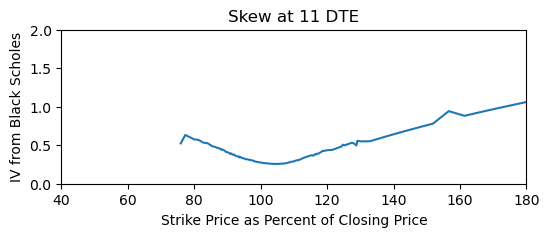

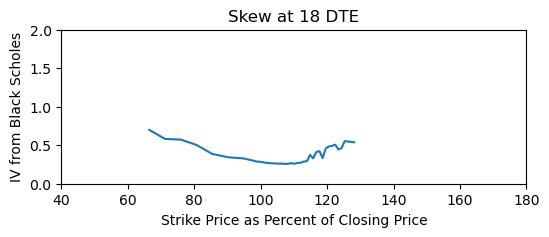

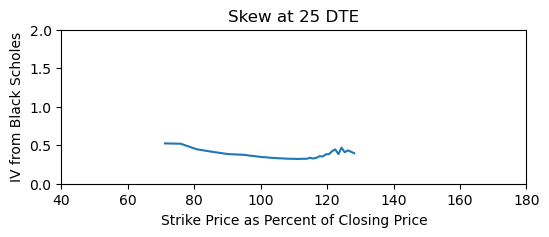

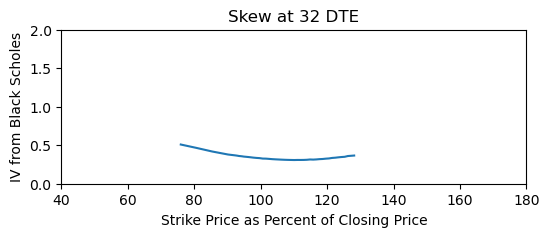

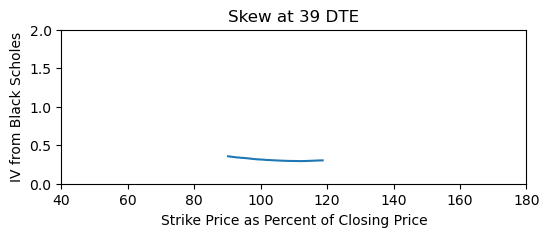

In [12]:
#graphing skew
def groupy_by_dte(dte, val, terms):
    grouped_mask = {}
    for i in terms:
        if i not in grouped_mask:
            grouped_mask[i] = []
        grouped_mask[i] = list(np.array(val)[dte == i])

    return list(grouped_mask.values())


df1["IV by DTE"] = [groupy_by_dte(row["DTE"], row["IV"], row["terms"]) for idx, row in df1.iterrows()]
df1["strike by DTE"] = [groupy_by_dte(row["DTE"], row["strike price"], row["terms"]) for idx, row in df1.iterrows()]

num_of_graphs = 5
for i in range(num_of_graphs):
    x = np.round(100 * np.array(df1.loc[0, "strike by DTE"][i]) / df1.loc[0, "closing price"][i], 5)
    y = df1.loc[0, "IV by DTE"][i]
    plt.figure(i, figsize=(6,2))
    plt.plot(x, y)
    plt.xlim(40, 180)
    plt.ylim(0, 2)
    DTE = df1.loc[0, "terms"][i]
    plt.title(f"Skew at {DTE} DTE")
    plt.xlabel("Strike Price as Percent of Closing Price")
    plt.ylabel("IV from Black Scholes")

In [57]:
# finding term structure
# creating strike divided by close column
df1["close adj strike"] = df1["strike price"] / df1["closing price"]

# finding closest to the money strike (ATM)
def index_closest_to(val, arr):
    arr = np.array(arr)
    closest = np.max(arr[arr < val])
    return np.where(arr == closest)

moneyness_val = 1 # 1 is ATM, 0.5 would be ITM, 1.5 would be OTM
#df1["moneyness_val"] = list(map(np.full, len(df1["close adj strike"]), moneyness_val))
df1["atm strike index"] = list(map(index_closest_to, np.full(len(df1["close adj strike"]), moneyness_val), df1["close adj strike"]))
print(np.array(df1["close adj strike"]).shape)

(5,)


C:\Users\semic\AppData\Local\Temp\ipykernel_22184\2658436938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["close adj strike"] = df1["strike price"] / df1["closing price"]
C:\Users\semic\AppData\Local\Temp\ipykernel_22184\2658436938.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["atm strike index"] = list(map(index_closest_to, np.full(len(df1["close adj strike"]), moneyness_val), df1["close adj strike"]))
